In [1]:
from madmex.overlay.extractions import zonal_stats_xarray
from madmex.io.vector_db import VectorDb
import numpy as np
import datacube
%matplotlib inline
import matplotlib
from datacube.api import GridWorkflow
from madmex.wrappers import gwf_query
from madmex.models import Tag
from madmex.modeling.supervised.rf import Model
import fiona
import pprint
import dill
from madmex.settings import SERIALIZED_OBJECTS_DIR
from madmex.util import randomword
import os


In [5]:
#Next product to adjust model
name_of_product = 's1_2_20m_resampled_10m_Jalisco_recipe_2017'
resolution = (-10,10)
tilesize = (50020,50020)
origin = (2426720, 977160)
proj4 = '+proj=lcc +lat_1=17.5 +lat_2=29.5 +lat_0=12 +lon_0=-102 +x_0=2500000 +y_0=0 +a=6378137 +b=6378136.027241431 +units=m +no_defs'


In [10]:
gwf_kwargs = {'region': 'Jalisco', 'begin': '2017-01-01', 'end':'2017-12-31',
              'product': name_of_product,'resolution': resolution, 'origin': origin,
              'proj4': proj4, 'tilesize': tilesize}

In [11]:
iterable = gwf_query(**gwf_kwargs)

In [12]:
lista_iter = list(iterable)

In [13]:
[lista_iter[x][0] for x in range(0,len(lista_iter))]

[(27, -32),
 (29, -30),
 (28, -33),
 (22, -30),
 (26, -31),
 (30, -30),
 (25, -26),
 (23, -30),
 (29, -31),
 (26, -27),
 (27, -26),
 (28, -32),
 (25, -30),
 (27, -33),
 (29, -27),
 (28, -28),
 (30, -29),
 (25, -27),
 (29, -32),
 (26, -30),
 (26, -33),
 (28, -31),
 (25, -31),
 (23, -31),
 (30, -28),
 (29, -28),
 (24, -32),
 (24, -30),
 (28, -27),
 (25, -33),
 (31, -27),
 (26, -29),
 (28, -30),
 (25, -32),
 (27, -31),
 (23, -32),
 (30, -27),
 (27, -27),
 (26, -25),
 (22, -31),
 (27, -30),
 (24, -33),
 (26, -26),
 (31, -28),
 (26, -32),
 (28, -26),
 (29, -33),
 (24, -29),
 (28, -29),
 (23, -29),
 (24, -31),
 (27, -29),
 (26, -28),
 (29, -29),
 (27, -28),
 (25, -29)]

In [14]:
var = lista_iter[53] #taking 29, -29 dc tile... just testing model fit for this dc tile

In [15]:
sr_0 = GridWorkflow.load(var[1],dask_chunks={'x': 2000, 'y': 2000, 'time': 1})

In [16]:
sr_0

<xarray.Dataset>
Dimensions:     (time: 1, x: 5002, y: 5002)
Coordinates:
  * time        (time) datetime64[ns] 2017-07-02
  * y           (y) float64 1.026e+06 1.026e+06 ... 9.762e+05 9.761e+05
  * x           (x) float64 2.428e+06 2.428e+06 ... 2.478e+06 2.478e+06
Data variables:
    blue_mean   (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    green_mean  (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    red_mean    (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    re1_mean    (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    re2_mean    (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    re3_mean    (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    nir_mean    (time, y, x) int16 dask.array<shape=(1, 5002, 5002), chunksize=(1, 2000, 2000)>
    swir1_mean  (time, y, x) int16 dask.array

In [63]:
matplotlib.rcParams['figure.figsize'] = [12, 8]

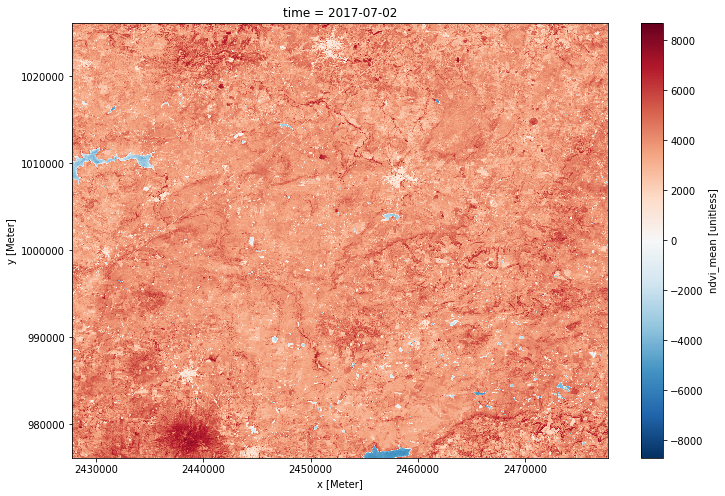

In [64]:
sr_0.ndvi_mean.plot()

In [10]:
#next lines to fit model to data

In [10]:
loader = VectorDb()
fc_train_0 = loader.load_training_from_dataset(dataset=sr_0,
                                               training_set='mex_nacional_resampled_31', sample=0.3)
# Evaluate the generator (safe to do here since the data is relatively small)
fc_train_0 = list(fc_train_0)


In [11]:
pprint.pprint(fc_train_0[0])

{'geometry': {'coordinates': [[[2467532.9636065355, 998662.5320861542],
                               [2467532.7025352214, 998657.1013667968],
                               [2467531.9455928416, 998651.7240380897],
                               [2467530.7000686396, 998646.4518867258],
                               [2467528.977957214, 998641.335686549],
                               [2467526.79584302, 998636.4247095353],
                               [2467524.1747406633, 998631.7662513083],
                               [2467521.139892536, 998627.4051756128],
                               [2467517.7205257276, 998623.383482275],
                               [2467513.9495705566, 998619.7399026724],
                               [2467509.8633434363, 998616.5095267581],
                               [2467505.501197126, 998613.7234650921],
                               [2467500.90514174, 998611.4085492168],
                               [2467496.119440146, 998609.5870732664],
  

In [12]:
qs = Tag.objects.filter(scheme='madmex_31')
tag_mapping = {x.id:x.numeric_code for x in qs}
tag_id_list = [x['properties']['class'] for x in fc_train_0]
fc_train = [{'geometry': x[0]['geometry'],
             'properties': {'code': tag_mapping[x[1]]},
             'type': 'feature'} for x in zip(fc_train_0, tag_id_list)]
pprint.pprint(fc_train[0])


{'geometry': {'coordinates': [[[2467532.9636065355, 998662.5320861542],
                               [2467532.7025352214, 998657.1013667968],
                               [2467531.9455928416, 998651.7240380897],
                               [2467530.7000686396, 998646.4518867258],
                               [2467528.977957214, 998641.335686549],
                               [2467526.79584302, 998636.4247095353],
                               [2467524.1747406633, 998631.7662513083],
                               [2467521.139892536, 998627.4051756128],
                               [2467517.7205257276, 998623.383482275],
                               [2467513.9495705566, 998619.7399026724],
                               [2467509.8633434363, 998616.5095267581],
                               [2467505.501197126, 998613.7234650921],
                               [2467500.90514174, 998611.4085492168],
                               [2467496.119440146, 998609.5870732664],
  

In [13]:
X_train, y_train = zonal_stats_xarray(sr_0, fc_train, 'code')

In [14]:
X_train

array([[3.61252747e+02, 5.94747253e+02, 8.16362637e+02, ...,
        2.12859341e+03, 1.45497379e+01, 2.69734467e+02],
       [5.01786517e+02, 8.58494382e+02, 8.15561798e+02, ...,
        2.00844944e+03, 1.85049021e+00, 1.52920181e+02],
       [3.91409091e+02, 6.03931818e+02, 8.48670455e+02, ...,
        2.00286364e+03, 2.77386904e+00, 3.38701263e+02],
       ...,
       [1.17405556e+03, 1.52811111e+03, 2.04403333e+03, ...,
        1.91921111e+03, 1.20350301e+00, 7.14451599e+01],
       [7.38100000e+02, 1.16884444e+03, 1.84877778e+03, ...,
        1.90084444e+03, 3.54980826e+00, 2.74390350e+02],
       [1.13774444e+03, 1.54475556e+03, 1.97992222e+03, ...,
        1.98217778e+03, 1.22327614e+00, 1.68419159e+02]])

In [15]:
y_train

array([ 3, 31, 27, ..., 28, 28, 28])

In [16]:
rf_model = Model()
rf_model.fit(X_train, y_train)

In [22]:
#save model to filesystem and db

In [17]:
name_model = 's2_fiona_test_model' + '_%d_%d' %(var[0][0],var[0][1])
product_model = 's2_20m_fiona_test_2_2018'
training_set = 'mex_nacional_resampled_31'
filename_model = '%s_%s.pkl' % (name_model, randomword(5))
filepath_model = os.path.join(SERIALIZED_OBJECTS_DIR, filename_model)


In [18]:
name_model

's2_fiona_test_model_29_-29'

In [19]:
filename_model

's2_fiona_test_model_28_-27_zpdla.pkl'

In [30]:
#write to filesystem:

In [21]:
with open(filepath_model, 'wb') as dst:
    dill.dump(rf_model, dst)

In [22]:
from madmex.models import Model

In [23]:
#write to db:

In [23]:
m = Model(name=name_model, path=filepath_model, training_set=training_set,recipe=product_model)

In [24]:
m.save() #django function

In [ ]:
#next lines for prediction... instead use ipynb predict_pipeline...

In [21]:
from madmex.models import PredictObject


In [19]:
segmentation_name = 's2_10m_some_scenes_fiona_test'

In [24]:
from django.contrib.gis.geos import Polygon


In [25]:
poly = Polygon.from_ewkt(sr_0.geobox.extent.wkt) 


In [26]:
query_set = PredictObject.objects.filter(the_geom__intersects=poly,
                                         segmentation_information__name=segmentation_name)

In [27]:
query_set

<QuerySet [<PredictObject: PredictObject object (1)>]>

In [28]:
path = query_set[0].path

In [30]:
with fiona.open(path) as src:
    X_pred, _ = zonal_stats_xarray(sr_0, src, 'id')
    y_pred = rf_model.predict(X_pred)
    fc_pred = [(x[0]['geometry'], x[1]) for x in zip(src, y_pred)]
    source_driver = src.driver
    source_crs = src.crs
    source_schema = src.schema
    fc_schema = {'geometry': 'Polygon',
             'properties': {'code': 'int'}}
    fc_pred_geojson = [{'geometry': x[0],
                      'properties': {'code': int(x[1])}, #why is necessary to transform to int ???
                      'type': 'feature'} for x in fc_pred]
    

In [ ]:
#write to filesystem

In [40]:
with fiona.open('/shared_volume/tasks/2019/fiona_cloud_usage/fiona_usage_training_resampled_3.shp','w', 
                driver=source_driver,
                crs=source_crs,
                schema=fc_schema) as dst:
    write = dst.write
    [write(feature) for feature in fc_pred_geojson]

In [75]:
X_pred

array([[ 4.72582853e+02,  6.54138793e+02,  8.40590542e+02, ...,
         1.62831603e+03,  4.97898006e+00,  1.76500183e+02],
       [ 4.53378039e+02,  6.39167451e+02,  8.23304706e+02, ...,
         1.64829804e+03,  1.08034515e+01,  2.78774841e+02],
       [ 5.18131373e+02,  7.28714510e+02,  9.73007451e+02, ...,
         1.66631255e+03,  9.25008011e+00,  1.99561813e+02],
       ...,
       [ 4.50549119e+02,  7.23715460e+02,  1.00260117e+03, ...,
         2.19814638e+03,  2.77769876e+00,  1.37038849e+02],
       [ 5.20480245e+02,  9.15958189e+02,  8.01500575e+02, ...,
         2.00508746e+03,  1.41661182e-01, -9.03293262e+03],
       [ 3.93991012e+02,  6.25972255e+02,  8.68356780e+02, ...,
         2.14075694e+03,  2.93682218e+00,  1.93665863e+02]])

In [ ]:
#next lines just to see some output step by step

In [76]:
from fiona.crs import to_string
with fiona.open(path) as src:
    print(to_string(src.crs))

+a=6378137 +b=6378136.027241431 +lat_0=12 +lat_1=17.5 +lat_2=29.5 +lon_0=-102 +no_defs +proj=lcc +units=m +x_0=2500000 +y_0=0


In [77]:
y_pre = rf_model.predict(X_pred)

In [78]:
y_pre

array([11, 11, 27, ..., 28, 31, 28])

In [79]:
with fiona.open(path) as src:
    fc_pred = [(x[0]['geometry'], x[1]) for x in zip(src, y_pre)]

In [80]:
pprint.pprint(fc_pred[0])

({'coordinates': [[(2427740.0, 1026160.0),
                   (2428250.0, 1026160.0),
                   (2428250.0, 1025650.0),
                   (2427740.0, 1025650.0),
                   (2427740.0, 1026160.0)]],
  'type': 'Polygon'},
 11)


In [81]:
with fiona.open(path) as source:
    source_driver = source.driver
    source_crs = source.crs
    source_schema = source.schema

In [82]:
fc_schema = {'geometry': 'Polygon',
             'properties': {'code': 'int'}}

In [83]:
fc_pred_geojson = [{'geometry': x[0],
                      'properties': {'code': int(x[1])}, #why is necessary to transform to int ???
                      'type': 'feature'} for x in fc_pred]

In [84]:
pprint.pprint(fc_pred_geojson[0])

{'geometry': {'coordinates': [[(2427740.0, 1026160.0),
                               (2428250.0, 1026160.0),
                               (2428250.0, 1025650.0),
                               (2427740.0, 1025650.0),
                               (2427740.0, 1026160.0)]],
              'type': 'Polygon'},
 'properties': {'code': 11},
 'type': 'feature'}


In [85]:
with fiona.open('/my_shared_volume/fiona_usage_training_resampled.shp','w', 
                driver=source_driver,
                crs=source_crs,
                schema=fc_schema) as dst:
    write = dst.write
    [write(feature) for feature in fc_pred_geojson]